# SIIM PCR Pneumothorax Classification and Segmentation Problem 

***This notebook contain the following solution :***

***Approach 1 :***

***A)*** First we classify the Chest X-Rays as either No Pneumothorax Present (Label:0) or Pneumothorax Present (Label:1). This part is the image classification part where we are applying transfer learning technique using the pre-trained model CheXNet (a 121 layer DenseNet model that is fine-tuned on Chest X-Ray images) to classify the images.

***B)*** Then, we build the segmentation part where we apply different segmentation models (Unet and Nested Unet) to predict the masks.


***C)*** Finally, we build the end pipeline where given an image we predict the label (0/1) and if the label is 1 we pass the image through the segmentation model to get the mask.

In [ ]:
#https://www.kaggle.com/danofer/ranzcr-chexnet-starter

***Mounting the Drive and installing the needed packages :***

In [1]:
# Mounting the Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Installing pydicom

!pip install pydicom

     |████████████████████████████████| 1.9MB 8.6MB/s 


In [3]:
#installing the libraries:

import pandas as pd
import numpy as np
import pydicom
from glob import glob
import glob2
from tqdm import tqdm
import shutil
import os
import pydicom
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import warnings
from joblib import Parallel, delayed
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
import tensorflow as tf
import keras
# tf.enable_eager_execution()
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
# from hilbert import hilbertCurve
import imgaug.augmenters as iaa
import numpy as np
import random as rn
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, Callback
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
# import tensorflow.keras.applications.efficientnet as efn
from tensorflow.keras import Sequential
from keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import densenet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, AveragePooling2D

In [6]:
%cd /content/drive/MyDrive/Self \Case \Study \2/DATASET/ 

/content/drive/MyDrive/Self Case Study 2/DATASET


***Loading the Train CSV file :***

In [7]:
final_train_df = pd.read_csv('Train Dataset/siim/final_train_data.csv')
final_train_df.head(2)

,ImageId,EncodedPixels,ImagePath,MaskPath,ImagePath_Png
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1,Train Dataset/siim/train_dicom_images/1.2.276....,Train Dataset/siim/train_mask_png_images/1.2.2...,Train Dataset/siim/train_png_images/1.2.276.0....
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...,Train Dataset/siim/train_dicom_images/1.2.276....,Train Dataset/siim/train_mask_png_images/1.2.2...,Train Dataset/siim/train_png_images/1.2.276.0....


In [8]:
imagePath = 'Train Dataset/siim/train_png_images/'
maskPath = 'Train Dataset/siim/train_mask_png_images/'

***Creating the binary labels for the classification model :***

In [9]:
final_train_df['Target'] = final_train_df[' EncodedPixels'].apply(lambda x : 0 if x == '-1' else 1)

In [10]:
final_train_df.head(2)

,ImageId,EncodedPixels,ImagePath,MaskPath,ImagePath_Png,Target
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1,Train Dataset/siim/train_dicom_images/1.2.276....,Train Dataset/siim/train_mask_png_images/1.2.2...,Train Dataset/siim/train_png_images/1.2.276.0....,0
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...,Train Dataset/siim/train_dicom_images/1.2.276....,Train Dataset/siim/train_mask_png_images/1.2.2...,Train Dataset/siim/train_png_images/1.2.276.0....,1


If no RLE value is present, i.e. if EncodedPixel column has value '-1' we are assigning it a label 0 else label 1.

In [11]:
#Getting all the paths of the train png images:

imagePath = final_train_df['ImagePath_Png']

In [ ]:
imagePath

0        Train Dataset/siim/train_png_images/1.2.276.0....
1        Train Dataset/siim/train_png_images/1.2.276.0....
2        Train Dataset/siim/train_png_images/1.2.276.0....
3        Train Dataset/siim/train_png_images/1.2.276.0....
4        Train Dataset/siim/train_png_images/1.2.276.0....
                               ...                        
12042    Train Dataset/siim/train_png_images/1.2.276.0....
12043    Train Dataset/siim/train_png_images/1.2.276.0....
12044    Train Dataset/siim/train_png_images/1.2.276.0....
12045    Train Dataset/siim/train_png_images/1.2.276.0....
12046    Train Dataset/siim/train_png_images/1.2.276.0....
Name: ImagePath_Png, Length: 12047, dtype: object

In [ ]:
load_dir = os.getcwd()
print(load_dir)

/content/drive/My Drive/Self Case Study 2/DATASET


In [12]:
# Getting the labels :
labels = final_train_df["Target"]

In [ ]:
labels

0        0
1        1
2        0
3        1
4        1
        ..
12042    0
12043    1
12044    1
12045    0
12046    0
Name: Target, Length: 12047, dtype: int64

In [ ]:
labels.shape

(12047,)

We have total 12,047 records in train dataset.

***Loading the Test Dataset :***

In [ ]:
test_df = pd.read_csv('Train Dataset/siim/test_dicom_images.csv')
test_df.head(2)

,ImageId,ImagePath
0,ID_c68e114ba,Train Dataset/siim/test_dicom_images/ID_c68e11...
1,ID_b5a797789,Train Dataset/siim/test_dicom_images/ID_b5a797...


***Converting the Dicom images to PNG format to be used later :***

In [ ]:
##https://www.kaggle.com/onealbao/dicom-to-jpeg-conversion-kernel

def dicom2png(file):
    '''
    This function inputs the path of the image to be read
    and create a .png format for the same image and store in the path created.
    '''
    ds = pydicom.read_file(str(file))
    img = ds.pixel_array
    # formatting the image to make training the network faster.
    img = cv2.resize(img, (256,256) )
    fname = file.replace('.dcm','.png')
    fname = fname.replace('_dicom','_png')
    cv2.imwrite(fname, img)

In [ ]:
for file in tqdm(test_df['ImagePath']):
    dicom2png(file)

100%|██████████| 3205/3205 [27:38<00:00,  1.93it/s]


In [ ]:
print(os.listdir('Train Dataset/siim/test_png_images/')[10])

ID_6daeaec68.png


In [ ]:
#Saving the PNG image paths in the Test Dataframe :

test_df['ImagePath_Png'] = 'Train Dataset/siim/test_png_images/'+ test_df['ImageId']+'.png'
test_df.head(2)

,ImageId,ImagePath,ImagePath_Png
0,ID_c68e114ba,Train Dataset/siim/test_dicom_images/ID_c68e11...,Train Dataset/siim/test_png_images/ID_c68e114b...
1,ID_b5a797789,Train Dataset/siim/test_dicom_images/ID_b5a797...,Train Dataset/siim/test_png_images/ID_b5a79778...


In [ ]:
#Getting the paths of the png images:
imagePath_test = test_df['ImagePath_Png']

In [ ]:
imagePath_test

0       Train Dataset/siim/test_png_images/ID_c68e114b...
1       Train Dataset/siim/test_png_images/ID_b5a79778...
2       Train Dataset/siim/test_png_images/ID_490a04f5...
3       Train Dataset/siim/test_png_images/ID_823ca20e...
4       Train Dataset/siim/test_png_images/ID_5face276...
                              ...                        
3200    Train Dataset/siim/test_png_images/ID_a9cc917b...
3201    Train Dataset/siim/test_png_images/ID_5dc70172...
3202    Train Dataset/siim/test_png_images/ID_f1b5e537...
3203    Train Dataset/siim/test_png_images/ID_ba7f28da...
3204    Train Dataset/siim/test_png_images/ID_77ab447a...
Name: ImagePath_Png, Length: 3205, dtype: object

***Splitting the Train Dataset into Train and CV Dataset:***

In [13]:
trainPath, validPath, trainLabels, validLabels = train_test_split(imagePath, labels, test_size = 0.1, random_state = 27, stratify=labels)

In [14]:
print('Total Train Dataset Size : ', trainPath.shape[0])
print('Total Valid Dataset Size : ', validPath.shape[0])

Total Train Dataset Size :  10842
Total Valid Dataset Size :  1205


We have a total of 10,842 records in the Train Portion and the remaining 1205 records are to be treated as CV or test data for checking model performance.

In [ ]:
trainLabels

5943     0
1455     0
1631     0
10874    0
727      0
        ..
2574     1
4568     0
9675     0
10061    0
335      0
Name: Target, Length: 10842, dtype: int64

***Handling the Data Imbalance Problem :***

In [ ]:
#Getting the count of the records present in train and cv dataset:
trainCount=trainLabels.value_counts()
validCount = validLabels.value_counts()

In [ ]:
#Getting the count of individual classes:

totalTrainCount = trainLabels.shape[0]
totalPosCount = trainCount[1]
totalNegCount = trainCount[0]

print('Total Train Labels : ', totalTrainCount)
print('Total Train Positive Labels : ', totalPosCount)
print('Total Train Negative Labels : ', totalNegCount)

Total Train Labels :  10842
Total Train Positive Labels :  2402
Total Train Negative Labels :  8440


We have imbalance data as the count of the Positve class far outdo the count for the negative class. This is a pretty common incident in the medical domain.

We need to handle this data imbalance problem so that the model doesnt become too biased for the majority class. To make sure that both the classes contribute to the loss equally, we give weights to each class. ***This weight is inversely proportional to the frequency of the class.***

In [ ]:
#Finding the frequency of each class: Freq = count_of_class/total_records_present

posFreq = round((totalPosCount/totalTrainCount),2)
negFreq = round((totalNegCount/totalTrainCount),2)

print('Frequency Of Positive Class : ', posFreq)
print('Frequency Of Negataive Class : ', negFreq)

Frequency Of Positive Class :  0.22
Frequency Of Negataive Class :  0.78


As expected, the frequency of the positive class is only 0.22 and the negative class has frequency of 0.78.

In [ ]:
#Assigning the weights of each class : 

pos_weights = negFreq
neg_weights = posFreq

In [ ]:
type(pos_weights)

numpy.float64

We need to check the contribution of each class on the loss so that the model remain unbiased to either class.

We calculate this ***contribution of each class as the product of the class_weight and the class_frequency***.

In [ ]:
#Getting the contribution of individual class :

pos_contribution = posFreq * pos_weights
neg_contribution = negFreq * neg_weights

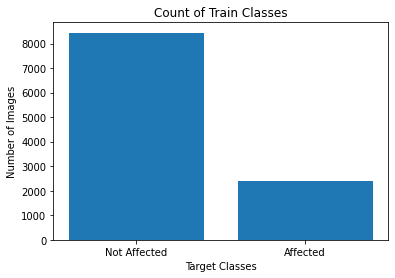

In [ ]:
#Plotting the count of individual class:

classes = ['Not Affected', 'Affected']
count = [totalNegCount,totalPosCount]
plt.bar(classes,count)
plt.xlabel('Target Classes')
plt.ylabel('Number of Images')
plt.title('Count of Train Classes')
plt.show()

Without the class weight assignment, the loss would have been more effected by the negative (majority) class.

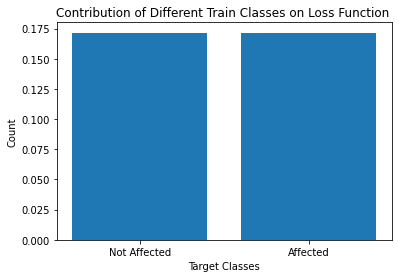

In [ ]:
#Plotting the contribution of each class after assigning the class weights:

classes = ['Not Affected', 'Affected']
count = [neg_contribution,pos_contribution]
plt.bar(classes,count)
plt.xlabel('Target Classes')
plt.ylabel('Count')
plt.title('Contribution of Different Train Classes on Loss Function ')
plt.show()

When given the weights properly, both classes effect the loss similarly. 

We have thus solved the data imbalance problem.

***Data Augmentaion Problem:***

In [15]:
import random

In [16]:
#https://www.kaggle.com/danofer/ranzcr-chexnet-starter/output?select=submission.csv
#https://www.tensorflow.org/tutorials/images/data_augmentation

def build_decoder(with_labels=True, target_size=(300, 300)):
    def decode(path):
        file_bytes = tf.io.read_file(path)
        img = tf.image.decode_png(file_bytes, channels=3)
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, target_size)

        return img
    
    def decode_with_labels(path, label):
        return decode(path), label
    
    return decode_with_labels if with_labels else decode

def build_augmenter(with_labels=True):
    def augment(img):
        number = random.randint(1,5)
        seed = (1, 5)
        if number == 1:
            img = tf.image.stateless_random_flip_left_right(img,seed)
            img = tf.image.stateless_random_contrast(img,0.2, 0.5,seed)
        if number == 2:
            img = tf.image.stateless_random_flip_up_down(img,seed)
            img = tf.image.stateless_random_brightness(img, 0.2,seed)
        if number == 3:
            img = tf.image.stateless_random_flip_left_right(img,seed)
            img = tf.image.stateless_random_saturation(img, 0.2, 0.5,seed)
        if number == 4:
            img = tf.image.stateless_random_flip_up_down(img,seed)
            img = tf.image.stateless_random_hue(img, 0.2,seed)
        if number == 5:
            img = tf.image.stateless_random_flip_left_right(img,seed)
            img = tf.image.adjust_gamma(img, 0.2)
        return img
    
    def augment_with_labels(img, label):
        return augment(img), label
    
    return augment_with_labels if with_labels else augment

def build_dataset(paths, labels=None, bsize=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024,cache_dir=""):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.map(decode_fn, num_parallel_calls=AUTO)
    dset = dset.cache(cache_dir) if cache else dset
    dset = dset.map(augment_fn, num_parallel_calls=AUTO) if augment else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(shuffle) if shuffle else dset
    dset = dset.batch(bsize).prefetch(AUTO)
    
    return dset

In [30]:
#Building the decoder for building the Train and Valid Dataset:

decoder = build_decoder(with_labels=True, target_size=(256, 256))
print(decoder)

<function build_decoder.<locals>.decode_with_labels at 0x7f6cf74e2440>


In [ ]:
#Creating the Augmented Train and Valid Datasets:

dtrain = build_dataset(
    trainPath, trainLabels, bsize=16, decode_fn=decoder,cache_dir='Kaggle/tf_cache'
)

dvalid = build_dataset(
    validPath, validLabels, bsize=16, 
    repeat=False, shuffle=False, augment=False, decode_fn=decoder,cache_dir='Kaggle/tf_cache'
)

In [ ]:
print('Train Dataset : ',dtrain)
print('Valid Dataset : ',dvalid)

Train Dataset :  <PrefetchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int64)>
Valid Dataset :  <PrefetchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int64)>


In [ ]:
#Assigning the necessary class weights
class_weight = {0: neg_weights, 1: pos_weights}

***Creating the Classification Model using Pre-Trained CheXNet model :***

In [23]:
#Creating the model:

#Defining the model:
base_model = densenet.DenseNet121(weights = None, include_top=False, input_shape=(256,256,3))

#Adding a dummy layer so that pre-trained weights can be loaded properly. This dummy layer is removed later
predictions = tf.keras.layers.Dense(14,activation='sigmoid', name='predictions')(base_model.output)

base_model2 = tf.keras.Model(inputs = base_model.input, outputs = predictions)

#Loading the pre-trained chexnet weights
base_model2.load_weights('brucechou1983_CheXNet_Keras_0.3.0_weights.h5')

#Removing the dummy layer
base_model2.layers.pop()

#Freezing the model
base_model2.trainable = False

#Adding a pooling layer 
new_base_model = tf.keras.layers.GlobalAveragePooling2D()(base_model2.layers[-3].output)

#Adding a dropout layer
#new_base_model = tf.keras.layers.Dropout(0.2)(new_base_model)

#Adding the final Dense layer for prediction
new_base_model = tf.keras.layers.Dense(1, activation='sigmoid')(new_base_model)

#Model built
final_new_model = tf.keras.Model(base_model2.input, new_base_model)

In [24]:
#Displaying the Last 6 layers
final_new_model.layers[-6:]

In [ ]:
#Displaying the last few layer of the original pre-trained chexnet model
base_model2.layers[-5:-1]

In [ ]:
#Displaying the model:

final_new_model.summary(line_length = 150)

Model: "model_5"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_3 (InputLayer)                             [(None, 256, 256, 3)]            0                                                                   
______________________________________________________________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D)                 (None, 262, 262, 3)              0                 input_3[0][0]                                     
______________________________________________________________________________________________________________________________________________________
conv1/conv (Conv2D)                              (None, 128, 128, 64)        

There are a total of 1025 trainable parameters in the Dense layer. These are divided between two tf.Variable objects, the weights and biases.

In [ ]:
len(final_new_model.trainable_variables)

2

Checking the input and output of the model created:

In [ ]:
final_new_model.inputs, final_new_model.outputs

([<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_4')>],
 [<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_3')>])

In [ ]:
#Count of the total records in train:
trainPath.shape[0]

10842

***Creating the Callbacks :***

In [ ]:
BATCH_SIZE = 16
#total number of datapooints that should be passed through the network in individual epochs. This is used when we are generating data through augmentations
weighted_steps_per_epoch = trainPath.shape[0] // BATCH_SIZE

#Callback for saving the weights 
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'chexnet_model.h5', save_best_only=True, monitor='val_auc', mode='max',restore_best_weights=True)

#Callback for the ReduceLROnPlateau
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_auc", patience=3, min_lr=1e-6, mode='max')

#Callback to stop training if the metric value doesnt change for 6 epochs
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', min_delta=0.0001, patience=6, mode='max',restore_best_weights=True)

***Defining the Metrics:***

In [26]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

#Adam optimizer
optim = tf.keras.optimizers.Adam(0.0001)

In [ ]:
  #Compile the model:
  final_new_model.compile(optimizer=optim,loss='binary_crossentropy',metrics=[METRICS])

In [ ]:
dtrain,dvalid

(<PrefetchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int64)>)

***Training the model :***

Training the model for shorter duration at a time because the colab is getting disconnected very randomly and very quickly. 

Also, most of the time we didnt get GPU and had to be trained on CPU so time taken for each epoch is very long (approx 35 mins/epoch).

In [ ]:
history = final_new_model.fit(
    dtrain, 
    epochs=5, # training for smaller epochs at a time because kernel is getting disconnected very easily.
    verbose=1,
    callbacks=[checkpoint, lr_reducer,early_stop],
    steps_per_epoch=weighted_steps_per_epoch,
    validation_data=dvalid,
    
    #Giving the class weights here:
    class_weight=class_weight)

Epoch 1/5
677/677 [==============================] - 1263s 2s/step - loss: 0.2367 - tp: 380.5206 - fp: 859.6431 - tn: 3379.7847 - fn: 812.0280 - accuracy: 0.7035 - precision: 0.2748 - recall: 0.2494 - auc: 0.5775 - val_loss: 0.6265 - val_tp: 148.0000 - val_fp: 219.0000 - val_tn: 724.0000 - val_fn: 125.0000 - val_accuracy: 0.7171 - val_precision: 0.4033 - val_recall: 0.5421 - val_auc: 0.7705
Epoch 2/5
677/677 [==============================] - 235s 348ms/step - loss: 0.2292 - tp: 785.6239 - fp: 1495.6313 - tn: 2731.5885 - fn: 419.1327 - accuracy: 0.6460 - precision: 0.3437 - recall: 0.6467 - auc: 0.7108 - val_loss: 0.5943 - val_tp: 173.0000 - val_fp: 234.0000 - val_tn: 709.0000 - val_fn: 100.0000 - val_accuracy: 0.7253 - val_precision: 0.4251 - val_recall: 0.6337 - val_auc: 0.7852
Epoch 3/5
677/677 [==============================] - 178s 263ms/step - loss: 0.2206 - tp: 826.7050 - fp: 1494.6239 - tn: 2742.4499 - fn: 368.1976 - accuracy: 0.6597 - precision: 0.3524 - recall: 0.6768 - auc: 

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
auc = history.history['auc']
precision = history.history['precision']
recall = history.history['recall']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_auc = history.history['val_auc']
val_precision = history.history['val_precision']
val_recall = history.history['val_recall']

In [ ]:
print("Metric Values after Training first 5 Epochs : \n")
print('Train Accuracy : ', acc)
print('Train Loss : ', loss)
print('Train AUC : ', auc)
print('Train Precision : ', precision)
print('Train Recall : ', recall)
print('Train Val_Accuracy : ', val_acc)
print('Train Val_Loss : ', val_loss)
print('Train Val_Auc : ', val_auc)
print('Train Val_Precision : ', val_precision)
print('Train Val_Recall : ', val_recall)
print("==========================================")

Metric Values after Training first 5 Epochs : 

Train Accuracy :  [0.670236349105835, 0.6407865285873413, 0.6487259864807129, 0.6531572937965393, 0.654634416103363]
Train Loss :  [0.23398947715759277, 0.22710101306438446, 0.22053559124469757, 0.2157195657491684, 0.2124169021844864]
Train AUC :  [0.6354421973228455, 0.7209659814834595, 0.7459319233894348, 0.7512601613998413, 0.7627031207084656]
Train Precision :  [0.31549471616744995, 0.34471920132637024, 0.356234610080719, 0.36011478304862976, 0.36686867475509644]
Train Recall :  [0.424979031085968, 0.6828559637069702, 0.7228464484214783, 0.7345317602157593, 0.749484121799469]
Train Val_Accuracy :  [0.7171052694320679, 0.7253289222717285, 0.7253289222717285, 0.7236841917037964, 0.7097039222717285]
Train Val_Loss :  [0.626529335975647, 0.594288170337677, 0.5703458189964294, 0.5562014579772949, 0.5501455068588257]
Train Val_Auc :  [0.7704893350601196, 0.7852287292480469, 0.7918633222579956, 0.7981055974960327, 0.8029378056526184]
Train V

Loading the modified weights and training for the next few epochs.

In [ ]:
final_new_model.load_weights("chexnet_model.h5")

In [ ]:
final_new_model.compile(optimizer=optim,loss='binary_crossentropy',metrics=[METRICS])

In [ ]:
history_epoch_5to9 = final_new_model.fit(
    dtrain, 
    epochs=10, # training for smaller epochs at a time because kernel is getting disconnected very easily.
    verbose=1,
    callbacks=[checkpoint, lr_reducer,early_stop],
    steps_per_epoch=weighted_steps_per_epoch,
    validation_data=dvalid,
    class_weight=class_weight)

Epoch 1/10
677/677 [==============================] - 227s 303ms/step - loss: 0.2085 - tp: 1077.9572 - fp: 1820.3584 - tn: 3365.7950 - fn: 383.8658 - accuracy: 0.6687 - precision: 0.3718 - recall: 0.7382 - auc: 0.7714 - val_loss: 0.5378 - val_tp: 206.0000 - val_fp: 277.0000 - val_tn: 666.0000 - val_fn: 67.0000 - val_accuracy: 0.7171 - val_precision: 0.4265 - val_recall: 0.7546 - val_auc: 0.8081
Epoch 2/10
677/677 [==============================] - 223s 330ms/step - loss: 0.2057 - tp: 881.1681 - fp: 1490.8746 - tn: 2751.9233 - fn: 308.0103 - accuracy: 0.6625 - precision: 0.3654 - recall: 0.7388 - auc: 0.7671 - val_loss: 0.5175 - val_tp: 200.0000 - val_fp: 240.0000 - val_tn: 703.0000 - val_fn: 73.0000 - val_accuracy: 0.7426 - val_precision: 0.4545 - val_recall: 0.7326 - val_auc: 0.8124
Epoch 3/10
677/677 [==============================] - 223s 330ms/step - loss: 0.2051 - tp: 862.1018 - fp: 1434.6814 - tn: 2797.7257 - fn: 337.4676 - accuracy: 0.6704 - precision: 0.3730 - recall: 0.7116 - 

In [ ]:
acc = history_epoch_5to9.history['accuracy']
loss = history_epoch_5to9.history['loss']
auc = history_epoch_5to9.history['auc']
precision = history_epoch_5to9.history['precision']
recall = history_epoch_5to9.history['recall']

val_acc = history_epoch_5to9.history['val_accuracy']
val_loss = history_epoch_5to9.history['val_loss']
val_auc = history_epoch_5to9.history['val_auc']
val_precision = history_epoch_5to9.history['val_precision']
val_recall = history_epoch_5to9.history['val_recall']

Loading the model again:

In [ ]:
final_new_model.load_weights("chexnet_model.h5")

In [ ]:
final_new_model.compile(optimizer=optim,loss='binary_crossentropy',metrics=[METRICS])

In [ ]:
history_epoch_10to14 = final_new_model.fit(
    dtrain, 
    epochs=5, # training for smaller epochs at a time because kernel is getting disconnected very easily.
    verbose=1,
    callbacks=[checkpoint, lr_reducer,early_stop],
    steps_per_epoch=weighted_steps_per_epoch,
    validation_data=dvalid,
    class_weight=class_weight)

Epoch 1/5
677/677 [==============================] - 1739s 3s/step - loss: 0.1708 - tp: 960.7670 - fp: 1158.4425 - tn: 3080.4322 - fn: 232.3348 - accuracy: 0.7477 - precision: 0.4556 - recall: 0.8089 - auc: 0.8422 - val_loss: 0.5226 - val_tp: 224.0000 - val_fp: 295.0000 - val_tn: 648.0000 - val_fn: 49.0000 - val_accuracy: 0.7171 - val_precision: 0.4316 - val_recall: 0.8205 - val_auc: 0.8397
Epoch 2/5
677/677 [==============================] - 1630s 2s/step - loss: 0.1686 - tp: 973.1593 - fp: 1146.4528 - tn: 3097.7920 - fn: 214.5723 - accuracy: 0.7421 - precision: 0.4499 - recall: 0.8233 - auc: 0.8470 - val_loss: 0.5181 - val_tp: 222.0000 - val_fp: 288.0000 - val_tn: 655.0000 - val_fn: 51.0000 - val_accuracy: 0.7212 - val_precision: 0.4353 - val_recall: 0.8132 - val_auc: 0.8480
Epoch 3/5
677/677 [==============================] - 1764s 3s/step - loss: 0.1660 - tp: 965.9100 - fp: 1115.3791 - tn: 3131.8142 - fn: 218.8732 - accuracy: 0.7501 - precision: 0.4582 - recall: 0.8191 - auc: 0.855

In [ ]:
acc += history_epoch_10to14.history['accuracy']
loss += history_epoch_10to14.history['loss']
auc += history_epoch_10to14.history['auc']
precision += history_epoch_10to14.history['precision']
recall += history_epoch_10to14.history['recall']

val_acc += history_epoch_10to14.history['val_accuracy']
val_loss += history_epoch_10to14.history['val_loss']
val_auc += history_epoch_10to14.history['val_auc']
val_precision += history_epoch_10to14.history['val_precision']
val_recall += history_epoch_10to14.history['val_recall']

Loading the model again:

In [ ]:
final_new_model.load_weights("chexnet_model.h5")

In [ ]:
final_new_model.compile(optimizer=optim,loss='binary_crossentropy',metrics=[METRICS])

In [ ]:
history_epoch_19to24 = final_new_model.fit(
    dtrain, 
    epochs=5, # training for longer results in a better model - but timed out on kernels
    verbose=1,
    callbacks=[checkpoint, lr_reducer,early_stop],
    steps_per_epoch=weighted_steps_per_epoch,
    validation_data=dvalid,
    class_weight=class_weight)

Epoch 1/5
677/677 [==============================] - 2388s 3s/step - loss: 0.1617 - tp: 963.2596 - fp: 998.9882 - tn: 3239.3496 - fn: 230.3791 - accuracy: 0.7670 - precision: 0.4852 - recall: 0.8071 - auc: 0.8632 - val_loss: 0.5018 - val_tp: 229.0000 - val_fp: 271.0000 - val_tn: 672.0000 - val_fn: 44.0000 - val_accuracy: 0.7410 - val_precision: 0.4580 - val_recall: 0.8388 - val_auc: 0.8598
Epoch 2/5
677/677 [==============================] - 2341s 3s/step - loss: 0.1559 - tp: 963.5516 - fp: 979.7581 - tn: 3269.9602 - fn: 218.7065 - accuracy: 0.7784 - precision: 0.4907 - recall: 0.8206 - auc: 0.8734 - val_loss: 0.4909 - val_tp: 224.0000 - val_fp: 246.0000 - val_tn: 697.0000 - val_fn: 49.0000 - val_accuracy: 0.7574 - val_precision: 0.4766 - val_recall: 0.8205 - val_auc: 0.8615
Epoch 3/5
677/677 [==============================] - 2268s 3s/step - loss: 0.1561 - tp: 961.8746 - fp: 976.4233 - tn: 3275.4794 - fn: 218.1991 - accuracy: 0.7778 - precision: 0.4883 - recall: 0.8239 - auc: 0.8706 -

In [ ]:
acc += history_epoch_19to24.history['accuracy']
loss += history_epoch_19to24.history['loss']
auc += history_epoch_19to24.history['auc']
precision += history_epoch_19to24.history['precision']
recall += history_epoch_19to24.history['recall']

val_acc += history_epoch_19to24.history['val_accuracy']
val_loss += history_epoch_19to24.history['val_loss']
val_auc += history_epoch_19to24.history['val_auc']
val_precision += history_epoch_19to24.history['val_precision']
val_recall += history_epoch_19to24.history['val_recall']

Loading the model again:

In [ ]:
final_new_model.load_weights("chexnet_model.h5")

In [ ]:
final_new_model.compile(optimizer=optim,loss='binary_crossentropy',metrics=[METRICS])

In [ ]:
history_epoch_25to30 = final_new_model.fit(
    dtrain, 
    epochs=5, # training for longer results in a better model - but timed out on kernels
    verbose=1,
    callbacks=[checkpoint, lr_reducer,early_stop],
    steps_per_epoch=weighted_steps_per_epoch,
    validation_data=dvalid,
    class_weight=class_weight)

Epoch 1/5
677/677 [==============================] - 2372s 3s/step - loss: 0.1560 - tp: 1194.6504 - fp: 1199.6740 - tn: 3987.2080 - fn: 266.4440 - accuracy: 0.7772 - precision: 0.4962 - recall: 0.8199 - auc: 0.8700 - val_loss: 0.4721 - val_tp: 220.0000 - val_fp: 224.0000 - val_tn: 719.0000 - val_fn: 53.0000 - val_accuracy: 0.7722 - val_precision: 0.4955 - val_recall: 0.8059 - val_auc: 0.8649
Epoch 2/5
677/677 [==============================] - 2283s 3s/step - loss: 0.1534 - tp: 995.3894 - fp: 928.5206 - tn: 3297.2920 - fn: 210.7743 - accuracy: 0.7915 - precision: 0.5189 - recall: 0.8285 - auc: 0.8786 - val_loss: 0.4665 - val_tp: 217.0000 - val_fp: 219.0000 - val_tn: 724.0000 - val_fn: 56.0000 - val_accuracy: 0.7738 - val_precision: 0.4977 - val_recall: 0.7949 - val_auc: 0.8654
Epoch 3/5
677/677 [==============================] - 2276s 3s/step - loss: 0.1568 - tp: 965.7935 - fp: 929.7537 - tn: 3307.9543 - fn: 228.4749 - accuracy: 0.7839 - precision: 0.5041 - recall: 0.8025 - auc: 0.8685

In [ ]:
acc += history_epoch_25to30.history['accuracy']
loss += history_epoch_25to30.history['loss']
auc += history_epoch_25to30.history['auc']
precision += history_epoch_25to30.history['precision']
recall += history_epoch_25to30.history['recall']

val_acc += history_epoch_25to30.history['val_accuracy']
val_loss += history_epoch_25to30.history['val_loss']
val_auc += history_epoch_25to30.history['val_auc']
val_precision += history_epoch_25to30.history['val_precision']
val_recall += history_epoch_25to30.history['val_recall']

In [ ]:
print("Metric Values after Training Next 28 Epochs : \n")
print('Train Accuracy : ', acc)
print('Train Loss : ', loss)
print('Train AUC : ', auc)
print('Train Precision : ', precision)
print('Train Recall : ', recall)
print('Train Val_Accuracy : ', val_acc)
print('Train Val_Loss : ', val_loss)
print('Train Val_Auc : ', val_auc)
print('Train Val_Precision : ', val_precision)
print('Train Val_Recall : ', val_recall)
print("==========================================")

Metric Values after Training Next 28 Epochs : 

Train Accuracy :  [0.670236349105835, 0.6407865285873413, 0.6487259864807129, 0.6531572937965393, 0.654634416103363, 0.6687, 0.6625, 0.6704, 0.6739, 0.6786, 0.6793, 0.6907, 0.6953, 0.7477, 0.7421, 0.7501, 0.7649, 0.7662, 0.7742798924446106, 0.7805576324462891, 0.7800959944725037, 0.7859120965003967, 0.7851735353469849, 0.7798804640769958, 0.7884047031402588, 0.7884970307350159, 0.7894202470779419, 0.7894202470779419]
Train Loss :  [0.23398947715759277, 0.22710101306438446, 0.22053559124469757, 0.2157195657491684, 0.2124169021844864, 0.2085, 0.2057, 0.2051, 0.1999, 0.1987, 0.2002, 0.1971, 0.1944, 0.1708, 0.1686, 0.166, 0.1616, 0.1625, 0.16077667474746704, 0.15837281942367554, 0.15744410455226898, 0.15684916079044342, 0.15705318748950958, 0.1564360409975052, 0.15412388741970062, 0.15498390793800354, 0.15514113008975983, 0.15270574390888214]
Train AUC :  [0.6354421973228455, 0.7209659814834595, 0.7459319233894348, 0.7512601613998413, 0.76270

***Evaluating the Final Trained Model :***

In [81]:
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix,precision_recall_curve,average_precision_score,accuracy_score

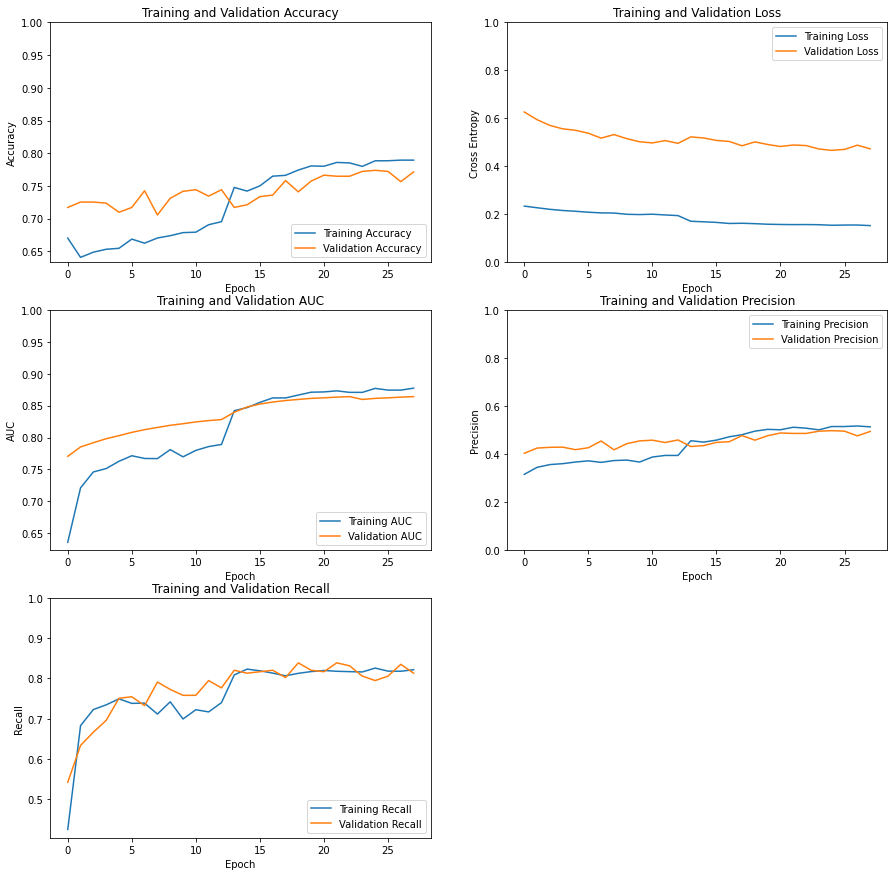

In [ ]:
#Plotting the metrics:

plt.figure(figsize=(15, 15))

#Plotting the Accuracy:
plt.subplot(3, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy')

#Plotting the Loss:
plt.subplot(3, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')

#Plotting the AUC:
plt.subplot(3, 2, 3)#3,2,1
plt.plot(auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.legend(loc='lower right')
plt.ylabel('AUC')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')

#Plotting the Precision:
plt.subplot(3, 2, 4)
plt.plot(precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.legend(loc='upper right')
plt.ylabel('Precision')
plt.ylim([0,1.0])
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')

#Plotting the Recall:
plt.subplot(3, 2, 5)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel('Recall')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')

#Showing all the graphs:
plt.show()

Getting the original Train and Valid dataset without the augmentations and class labels:

In [21]:
test_decoder = build_decoder(with_labels=False, target_size=(256, 256))

train_features = build_dataset(
    trainPath, bsize=BATCH_SIZE, repeat=False, 
    shuffle=False, augment=False, cache=False, 
    decode_fn=test_decoder
)

valid_features = build_dataset(
    validPath, bsize=BATCH_SIZE, repeat=False, 
    shuffle=False, augment=False, cache=False, 
    decode_fn=test_decoder
)

In [22]:
train_features, valid_features

(<PrefetchDataset shapes: (None, 256, 256, 3), types: tf.float32>,
 <PrefetchDataset shapes: (None, 256, 256, 3), types: tf.float32>)

Getting the predict probabilities on Valid Dataset:

In [28]:
valid_predictions_baseline = final_new_model.predict(valid_features, batch_size=16)

Getting the Metrics on the Valid Dataset:

In [32]:
valid_baseline_results = final_new_model.evaluate(dvalid,batch_size=16, verbose=0)

In [79]:
val_precision = round((valid_baseline_results[6]),3)
val_recall = round((valid_baseline_results[7]),3)
val_loss = round((valid_baseline_results[0]),3)
val_auc = round((valid_baseline_results[8]),3)
print('METRIC VALUES FOR VALID DATASET : \n')
print('PRECISION : ', val_precision)
print('RECALL : ', val_recall)
print('LOSS : ', val_loss)
print('AUC : ', val_auc)

METRIC VALUES FOR VALID DATASET : 

PRECISION :  0.494
RECALL :  0.813
LOSS :  0.473
AUC :  0.867


***Plotting the Graphs:***

Plotting the ROC Curve :

In [ ]:
#https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

def plot_roc(name, labels, predictions):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
  auc = round(metrics.auc(fp, tp),3)
  
  plt.figure(figsize=(8, 8))
  plt.plot(100*fp, 100*tp, label=name+" = " +str(auc), linewidth=2)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.grid(True)
  plt.title("ROC Curve")
  ax = plt.gca()
  ax.set_aspect('equal')

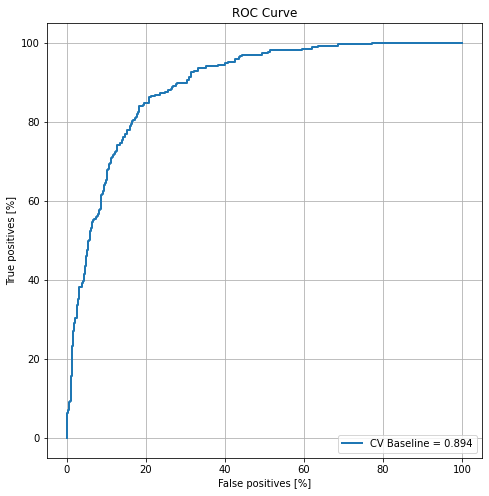

In [ ]:
#Plotting the ROC Curve on CV Dataset:
plot_roc("CV Baseline", validLabels, valid_predictions_baseline)
plt.legend(loc='lower right')

we got a AUC Score of 0.894 on the CV Dataset.

Plotting the Confusion Matrix:

We took the threshold at 0.5 and observed these values for the metrics.

In [50]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  tn = cm[0][0]
  fn = cm[1][0]
  fp = cm[0][1]
  tp = cm[1][1]

  sensitivity = round((tp/(tp+fn)),3)
  specificity = round((tn/(tn+fp)),3)
  accuracy = round(((tp + tn)/(tp+tn+fp+fn)),3)
  PPV = round((tp/(tp + fp)),3)
  NPV = round((tn/(tn + fn)),3)
  print('Total Records Detected : ', labels.shape[0])
  print('Total Pneumothorax Cases : ', np.sum(cm[1]))
  print("=====================================")
  print('True Negatives : ', tn)
  print('False Positives : ', fp)
  print('False Negatives : ', fn)
  print('True Positives : ', tp)
  print("=====================================")
  print('Accuracy : ', accuracy)
  print('PPV : ', PPV)
  print('NPV : ', NPV)
  print('Sensitivity : ', sensitivity)
  print('Specificity : ', specificity)
  print("=====================================")

  return tn,fn,fp,tp,sensitivity,specificity,accuracy,PPV,NPV

Total Records Detected :  1205
Total Pneumothorax Cases :  267
True Negatives :  735
False Positives :  203
False Negatives :  36
True Positives :  231
Accuracy :  0.802
PPV :  0.532
NPV :  0.953
Sensitivity :  0.865
Specificity :  0.784


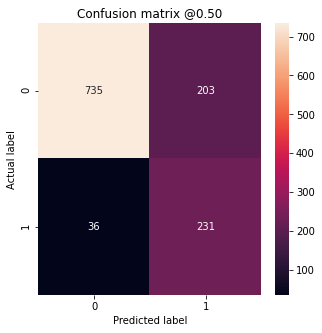

In [51]:
tn,fn,fp,tp,sensitivity,specificity,accuracy,PPV,NPV = plot_cm(validLabels, valid_predictions_baseline)

Sensitivity and Specificity are two of the most prominent metrics that are used to measure diagnostics tests.

***Sensitivity*** (TRUE POSITIVE RATE) is the probability that the model outputs positive given that the case is actually positive. It shows what portion of the positive class got correctly classified. 

This is also the Recall.


***Specificity*** (TRUE NEGATIVE RATE) is the probability that the model outputs negative given that the case is actually negative. It would mean determining the proportion of healthy people who were correctly identified by the model.

Positive predictive value (***PPV***) is the probability that people with a positive prediction truly have the disease. 

So, PPV of 0.532 means that if a person is predicted to have pneumothorax there is 53.4% probability that he actually have the disease.

This is also the Precision.



Negative predictive value (***NPV***) is the probability that people with a negative prediction truly don't have the disease. 

So, NPV of 0.953 means that if a person is predicted to not have pneumothorax there is 95.3% probability that he doesnt actually have the disease.

***Sensitivity*** and ***NPV*** are the most important metric values. Since we are dealing with medical data, we have to ***minimise the False Negative*** as the situation where the patient has the disease (ie true label = positive) but the model predicts him to be safe (ie predicted label = negative) can prove to be disastrous. We also need to ***maximise True Postive***.

So we want majority of the postive class to be correctly predicted. Hence, we need a high Sensitivity (TPR). Also , we need high NPV that shows that if the model predicts the person to be healthy, he is actually healthy.

Plotting the Precision_Recall Curve :

In [75]:
def plot_precision_recall_curve(name, labels, predictions):
  
  class_precision, class_recall, _ = precision_recall_curve(labels, predictions)
  average_precision = round((average_precision_score(labels, predictions)),3)

  plt.figure(figsize=(8, 8))
  plt.plot(100*class_recall, 100*class_precision, label=name +" = "+ str(average_precision), linewidth=2)
  plt.xlabel('Recall [%]')
  plt.ylabel('Precision [%]')
  #plt.xlim([-0.5,20])
  #plt.ylim([80,100.5])
  plt.grid(True)
  plt.legend()
  plt.title("Precision-Recalll Curve")
  ax = plt.gca()
  ax.set_aspect('equal')

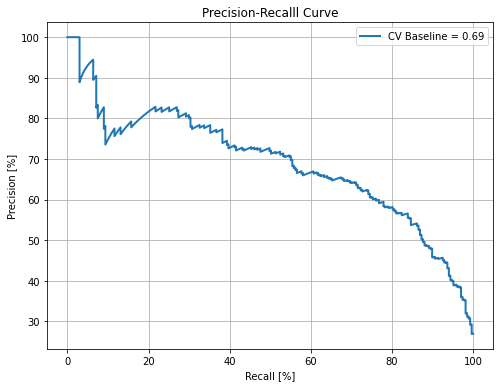

In [76]:
plot_precision_recall_curve("CV Baseline", validLabels, valid_predictions_baseline)

We got an Average Precision Score of 0.69 on CV Dataset.

The ***Precision-Recall curve*** (PRC) shows the trade-off between precision and recall.

A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate.

High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

Saving all the metric values in a dataframe:

In [91]:
data = [{'Values' : accuracy}, {'Values' : val_precision}, {'Values' : val_recall}, {'Values' : sensitivity}, 
        {'Values' : specificity}, {'Values' : PPV}, {'Values' : NPV}]

labels = ['Accuracy', 'Precision', 'Recall','Sensitivity', 'Specificity', 'PPV', 'NPV']
classification_metricValues_df = pd.DataFrame(data, index =labels) 

In [93]:
classification_metricValues_df

,Values
Accuracy,0.802
Precision,0.494
Recall,0.813
Sensitivity,0.865
Specificity,0.784
PPV,0.532
NPV,0.953


In [94]:
#Saving the metric df in disk:

classification_metricValues_df.to_csv('Train Dataset/siim/classification_metricValues_df.csv')

***Checking the Model on the Test Data given:***

Building the Test Dataset without Augmentations:

In [ ]:
test_decoder = build_decoder(with_labels=False, target_size=(256, 256))

dtest = build_dataset(
    imagePath_test, bsize=BATCH_SIZE, repeat=False, 
    shuffle=False, augment=False, cache=False, 
    decode_fn=test_decoder
)

In [ ]:
dtest

<PrefetchDataset shapes: (None, 256, 256, 3), types: tf.float32>

Reading the Test CSV file:

In [ ]:
submission_df = pd.read_csv('/content/drive/MyDrive/Self Case Study 2/DATASET/Test Dataset/stage_2_sample_submission.csv')

In [ ]:
submission_df.head(2)

,ImageId,EncodedPixels
0,ID_c68e114ba,-1
1,ID_b5a797789,-1


In [ ]:
#Using the Model to predict the Class Label (NOT MASK):

submission_df['Pneumothorax_Classification'] = final_new_model.predict(dtest, verbose=1)
submission_df.to_csv('/content/drive/MyDrive/Self Case Study 2/DATASET/Test Dataset/Pneumothorax_Classification_Submission.csv', index=False)
submission_df.head(2)

201/201 [==============================] - 574s 3s/step


,ImageId,EncodedPixels,Pneumothorax_Classification
0,ID_c68e114ba,-1,0.148873
1,ID_b5a797789,-1,0.308220


In [ ]:
submission_df.tail(10)

,ImageId,EncodedPixels,Pneumothorax_Classification
3195,ID_0f5f33d71,-1,0.512488
3196,ID_e42b91d9a,-1,0.461379
3197,ID_bd4fa896c,-1,0.578524
3198,ID_293b74bdf,-1,0.489248
3199,ID_74441d7a9,-1,0.701188
3200,ID_a9cc917b4,-1,0.385000
3201,ID_5dc70172e,-1,0.109129
3202,ID_f1b5e5378,-1,0.795560
3203,ID_ba7f28dac,-1,0.271849
3204,ID_77ab447a1,-1,0.524013


We have used the classification model to predict the probability of the class label. 

We will now create the segmentation model that will predict the mask. 

In [ ]:
#from keras import backend as K
#from tf.keras.backend as K